In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/sample_submission.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv


In [2]:
!pip install bioinfokit

     |████████████████████████████████| 84 kB 727 kB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.6-py3-none-any.whl size=57066 sha256=68b178cf46e5def1830d86157f4588d7a3735256372c618b2fe7306f013661ad
  Stored in directory: /root/.cache/pip/wheels/38/b2/a0/3f65c463d3faababa8cb5f3076e3bfc1c49fea2a736a49038a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=5ece7d8a3187b58064f8d19e07fe099c91782fcc10b5aa37f29b0d90a78214d5
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText


In [3]:



def training_model_metrics(model, X, Y):
    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=12, shuffle=True)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    model_acc = metrics.accuracy_score(test_y, y_pred)
    f1_measure = metrics.f1_score(test_y, y_pred, average='macro')
    model_precision = metrics.precision_score(test_y, y_pred, average='macro')
    model_recall = metrics.recall_score(test_y, y_pred, average='macro')
    print('Accuracy: %.3f, f1 measure: %.3f, precision: %.3f, recall: %.3f' % (model_acc, f1_measure, model_precision, model_recall))
    metrics.plot_confusion_matrix(model, test_x, test_y);
    plt.show()
    return model

def optimize_param(model, param, X_optim, Y_optim):
    rf_grid = RandomizedSearchCV(estimator=model, n_iter=30, param_distributions=param, scoring='f1_macro', n_jobs=-1,
                                 cv=5, verbose=2, random_state=12)
    print('Performance Metrics for ML Model of Dataset using optimized hyper-parameters')
    print('-----------------------------------------------------------------------')
    training_model_metrics(rf_grid, X_optim, Y_optim)
    print('The hyper-parameters with the best f1_macro performance:')
    print('----------------------------------------------------------')
    print(rf_grid.best_params_)


def evaluate_PC(model, user_input, user_output):
    train_x, test_x, train_y, test_y = train_test_split(user_input, user_output, test_size=0.2, random_state=12, shuffle=True)
    acc, comp = list(), list()

    for n in range(1, 16):
        pca = PCA(n_components=n)
        pca.fit(train_x)
        pca_transform = pca.fit_transform(train_x)
        cv = KFold(n_splits=5, shuffle=True, random_state=12)
        scores = cross_val_score(model, pca_transform, train_y, scoring='f1_macro', cv=cv, n_jobs=-1)
        acc.append(np.mean(scores))
        comp.append(n)
        print('> No of Components=%d, Accuracy=%.3f' % (n, np.mean(scores)))

    return acc, comp


def display_perf_plot(acc, comp):
    plt.plot(comp, acc)
    plt.title('PRINCIPAL COMPONENT ANALYSIS PERFORMANCE PLOT USING CROSS-VALIDATION')
    plt.axhline(y=max(acc), color='r', linestyle='--')
    plt.xlabel('NUMBER OF COMPONENTS')
    plt.ylabel('F1-MEASURE')
    plt.show()


def KFold_evaluation(model, X, Y):
    means, mins, maxs = list(), list(), list()
    folds = range(2, 13)
    for k in folds:
        cv = KFold(n_splits=k, shuffle=True, random_state=12)
        scores = cross_val_score(model, X, Y, scoring='f1_macro', cv=cv, n_jobs=-1)
        means.append(np.mean(scores))
        mins.append(np.mean(scores) - scores.min())
        maxs.append(scores.max() - np.mean(scores))
    plt.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    plt.title('CROSS-VALIDATION PERFORMANCE EVALUATION')
    plt.xlabel('NUMBER OF FOLDS')
    plt.ylabel('F1-MEASURE')
    plt.axhline(y=max(means), color='r', linestyle='--')
    plt.show()



In [4]:
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        Q1 = np.percentile(df[c], 25)
        Q3 = np.percentile(df[c], 75)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1)

    return multiple_outliers


In [5]:
from sklearn import preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from bioinfokit.visuz import cluster
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint, loguniform



In [6]:
data = pd.read_csv("/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv")
pd.options.display.max_columns = None
pd.options.display.max_rows = None

plt.rcParams["font.family"] = "Times New Roman"

X = data.drop(["ID","y"], axis=1)


# try dropping colinear values
X = X.drop(["Perimeter", "ConvexArea", "ShapeFactor3", "EquivDiameter", 
                       "MajorAxisLength", "MinorAxisLength", "Compactness", "ShapeFactor2", "Eccentricity"], axis=1)

Y = data['y']


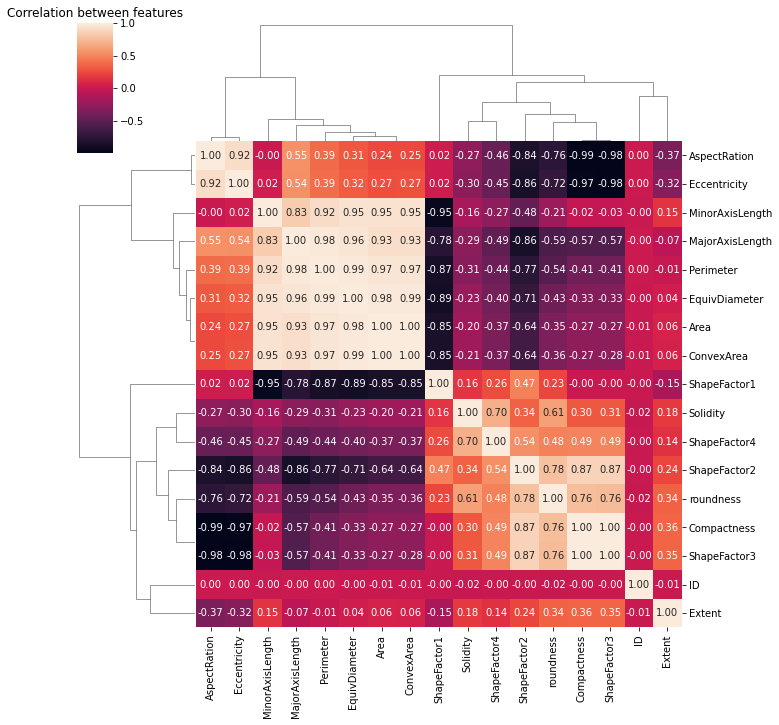

In [7]:
#Visualizing the correlation between the features
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation between features");
plt.show()


In [8]:
data = data.drop(detect_outliers(data,['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity',
                                       'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1',
                                       'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']), axis=0).reset_index(drop=True)
print('Number of of samples in the dataset after removing outliers: %d' % len(data))


Number of of samples in the dataset after removing outliers: 9705


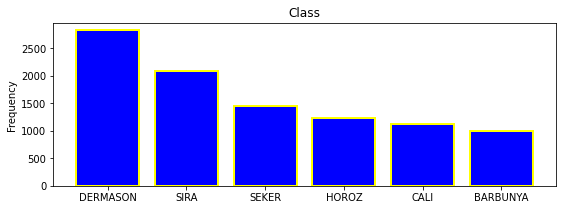

In [9]:
# Bar Chart to visualize the labels in the output variable
var = data['y']
varValue = var.value_counts()
plt.figure(figsize=(9,3));plt.bar(varValue.index, varValue, color= "blue", edgecolor="yellow", linewidth="2");
plt.xticks(varValue.index, varValue.index.values);plt.ylabel("Frequency");plt.title('Class');
plt.show()


In [10]:
# Convert Class String labels into Integers
lab_enc = preprocessing.LabelEncoder()
label_Y = lab_enc.fit_transform(Y)

# Normalize the input features of the dataset
normalizer = preprocessing.StandardScaler()
norm_X = normalizer.fit_transform(X)


In [11]:
# Visualizing the Principal Components in the feature space
pca = PCA()
pca.fit(norm_X)
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC" + str(i) for i in list(range(1, num_pc + 1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X.columns.values
loadings_df = loadings_df.set_index('variable')
# Screeplot of Principal Components
cluster.screeplot(obj=[pc_list, pca.explained_variance_ratio_])

In [12]:
# 2D Bi-plot of Principal Components
pca_scores = PCA().fit_transform(norm_X)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=X.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), colorlist=Y)


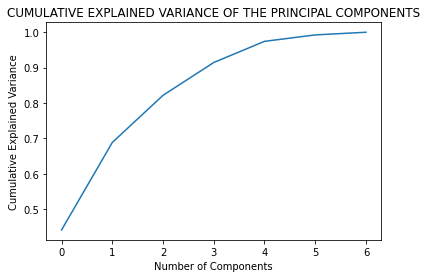

In [13]:

# Cumulative Explained Variance Plot
plt.plot(np.cumsum(pca.explained_variance_ratio_)); plt.title('CUMULATIVE EXPLAINED VARIANCE OF THE PRINCIPAL COMPONENTS')
plt.xlabel('Number of Components'); plt.ylabel('Cumulative Explained Variance')
plt.show()


In [14]:
################################################################
############### EXTREME GRADIENT BOOSTING ENSEMBLE #############
################################################################
print('******************XGBOOST CLASSIFICATION MODEL**************************')
xgb_model = XGBClassifier(random_state=12)

print('Performance metrics for XGBoost Classification of Original Data')
print('-----------------------------------------------------------------------')
print('-----------------------------------------------------------------------')
print('Performance Metrics for ML Model of Dataset using default hyper-parameters')
print('-----------------------------------------------------------------------')
#training_model_metrics(xgb_model, norm_X, label_Y)


******************XGBOOST CLASSIFICATION MODEL**************************
Performance metrics for XGBoost Classification of Original Data
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Performance Metrics for ML Model of Dataset using default hyper-parameters
-----------------------------------------------------------------------


-----------------------------------------------------------------------
Performance metrics for XGBoost Classification of SMOTE Balanced Data
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Performance Metrics for ML Model of Dataset using default hyper-parameters
-----------------------------------------------------------------------
[09:51:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.954, f1 measure: 0.953, precision: 0.954, recall: 0.953


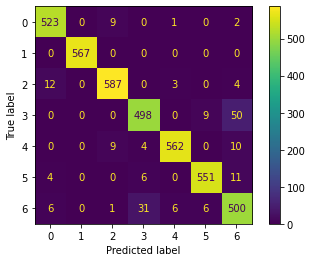

In [15]:
# Applying SMOTE technique on the dataset
print('-----------------------------------------------------------------------')
print('Performance metrics for XGBoost Classification of SMOTE Balanced Data')
print('-----------------------------------------------------------------------')
sm = SMOTE(random_state=12)
X_sm_xgb, Y_sm_xgb = sm.fit_resample(X, label_Y)
print('-----------------------------------------------------------------------')
print('Performance Metrics for ML Model of Dataset using default hyper-parameters')
print('-----------------------------------------------------------------------')
prediction_model = training_model_metrics(xgb_model, X_sm_xgb, Y_sm_xgb)

In [16]:
label_Y.shape

(10834,)

In [17]:
#print(X_sm_xgb.shape)
#print(Y_sm_xgb.shape)      

In [18]:
# PCA Dimensionality Reduction to 8 PCs (THIS THIS THIS)
print('Performance metrics for XGBoost Classification of SMOTE Dataset using 8 Principal Components')
print('-----------------------------------------------------------------------')
#pca_sm_xgb = PCA(n_components=8).fit_transform(X_sm_xgb)
#training_model_metrics(xgb_model, pca_sm_xgb, Y_sm_xgb)


Performance metrics for XGBoost Classification of SMOTE Dataset using 8 Principal Components
-----------------------------------------------------------------------


In [19]:
test_df = pd.read_csv('/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv')
done = pd.DataFrame()
done['ID'] = test_df['ID']
test_df = test_df.drop('ID', axis=1)

test_df = test_df.drop(["Perimeter", "ConvexArea", "ShapeFactor3", "EquivDiameter", 
                       "MajorAxisLength", "MinorAxisLength", "Compactness", "ShapeFactor2", "Eccentricity"], axis=1)

#no
normalizer = preprocessing.StandardScaler()
#no
norm_X_test = normalizer.fit_transform(test_df)

#pca_sm_xgb_test = PCA(n_components=8).fit_transform(norm_X_test)

#sm2 = SMOTE(random_state=12)
#X_sm_xgb = sm2.fit_resample(norm_X_test)


In [20]:
out = prediction_model.predict(test_df)

In [21]:
out

array([4, 3, 0, ..., 4, 3, 6])

In [22]:
label_out = lab_enc.inverse_transform(out)


In [23]:
label_out

array(['HOROZ', 'DERMASON', 'BARBUNYA', ..., 'HOROZ', 'DERMASON', 'SIRA'],
      dtype=object)

In [24]:
done['y'] = label_out

In [25]:
done.head()

,ID,y
0,10834,HOROZ
1,10835,DERMASON
2,10836,BARBUNYA
3,10837,DERMASON
4,10838,BOMBAY


In [26]:
final = done.to_csv('/kaggle/working/submission2.csv', index=False)